**Transfer Learning with Domain Adaptation**

We are applying domain adaptation while training our pre-trained model. 


In [0]:
%matplotlib inline

import numpy as np
from keras.layers import Input, Dense, Activation, BatchNormalization, PReLU, Dropout,Conv2D,MaxPooling2D,Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score24
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
from keras.datasets import mnist
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# our handwritten samples
from keras.preprocessing import image
train_path = '/content/drive/My Drive/TLDB/Shubham/Train/'
test_path = '/content/drive/My Drive/TLDB/Shubham/Test/'

In [0]:
from PIL import Image, ImageFilter
from matplotlib import pyplot as plt


def imageprepare(argv):
    """
    This function returns the pixel values.
    The imput is a png file location.
    """
    im = Image.open(argv).convert('L')
    width = float(im.size[0])
    height = float(im.size[1])
    newImage = Image.new('L', (28, 28), (255))  # creates white canvas of 28x28 pixels

    if width > height:  # check which dimension is bigger
        # Width is bigger. Width becomes 20 pixels.
        nheight = int(round((20.0 / width * height), 0))  # resize height according to ratio width
        if (nheight == 0):  # rare case but minimum is 1 pixel
            nheight = 1
            # resize and sharpen
        img = im.resize((20, nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight) / 2), 0))  # calculate horizontal position
        newImage.paste(img, (4, wtop))  # paste resized image on white canvas
    else:
        # Height is bigger. Heigth becomes 20 pixels.
        nwidth = int(round((20.0 / height * width), 0))  # resize width according to ratio height
        if (nwidth == 0):  # rare case but minimum is 1 pixel
            nwidth = 1
            # resize and sharpen
        img = im.resize((nwidth, 20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth) / 2), 0))  # caculate vertical pozition
        newImage.paste(img, (wleft, 4))  # paste resized image on white canvas

    # newImage.save("sample.png

    tv = list(newImage.getdata())  # get pixel values

    # normalize pixels to 0 and 1. 0 is pure white, 1 is pure black.
    tva = [(255 - x) * 1.0 / 255.0 for x in tv]
    #print(tva)
    return tva


result=[]
import numpy as np
import glob
files=(glob.glob(train_path+"/*.png")) #to list names of all the files inside given folder; i.e. relative path
n=len(files);
    
for indx in range(n):
        x=[imageprepare(files[indx])]#file path here
        newArr=[[0 for d in range(28)] for y in range(28)]
        k = 0
        for i in range(28):
            for j in range(28):
                newArr[i][j]=x[0][k]
                k=k+1
        result.append(newArr)
x_npa=np.asarray(result) # converting to NP ARRAY of size (n,28,28)
#     return x_npa
    




In [0]:
x_train_new = x_npa#our dataset
y_train_new = np.array([6,4,8,3,1,7,9,2,0,5,8,3,7,9,0,1,6,2,5,4])

#level2(SVM)
y_train_for_svm=y_train_new


(20, 28, 28)


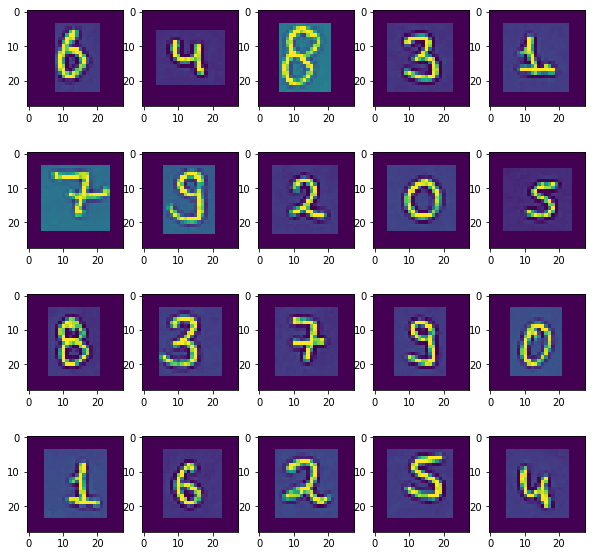

In [0]:
print(x_npa.shape)
plt.figure(figsize = (10, 10))

for i in range(20):
  plt.subplot(4,5,i+1)
  plt.imshow(x_npa[i])

In [0]:
result=[]
import numpy as np
import glob
files=(glob.glob(test_path+"/*.png")) #to list names of all the files inside given folder; i.e. relative path
n=len(files);
    
for indx in range(n):
        x=[imageprepare(files[indx])]#file path here
        newArr=[[0 for d in range(28)] for y in range(28)]
        k = 0
        for i in range(28):
            for j in range(28):
                newArr[i][j]=x[0][k]
                k=k+1
        result.append(newArr)
x_npa1=np.asarray(result) # converting to NP ARRAY of size (n,28,28)


In [0]:
x_test_new = x_npa1
y_test_new = np.array([8,2,1,3,0,0,4,3,4,9,7,9,1,8,7,6,5,2,5,6])

# for level2(SVM)
y_test_for_svm=y_test_new

(20, 28, 28)


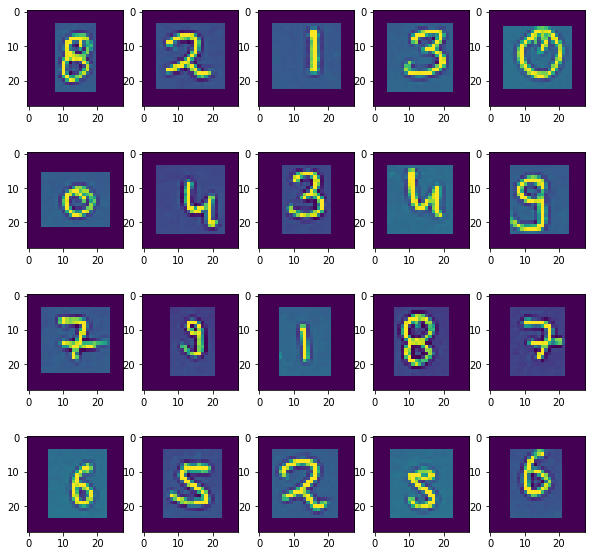

In [0]:
print(x_npa1.shape)
plt.figure(figsize = (10, 10))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.imshow(x_npa1[i])


In [0]:
# Preparing input for model at level 1

image_size=28;
x_train_total= np.concatenate([x_train_mnist,x_train_new])
x_test_total=  np.concatenate([x_test_mnist,x_test_new])

x_train_total = np.reshape(x_train_total, [-1, image_size, image_size, 1])#changing to (n, 28,28,1)
x_test_total = np.reshape(x_test_total, [-1, image_size, image_size, 1])

x_train_total = x_train_total.astype('float32') / 255
x_test_total = x_test_total.astype('float32') / 255



In [0]:
y_train_total= np.concatenate([y_train_mnist,y_train_new])
y_test_total=  np.concatenate([y_test_mnist,y_test_new])

y_train_domain=np.concatenate([np.zeros(x_train_mnist.shape[0]),np.ones(x_train_new.shape[0])])
y_test_domain=np.concatenate([np.zeros(x_test_mnist.shape[0]),np.ones(x_test_new.shape[0])])


In [0]:
#same functionality as onehotencoder
from keras.utils import np_utils

y_train_total = np_utils.to_categorical(y_train_total).astype('int32')
y_test_total = np_utils.to_categorical(y_test_total)

y_test_domain = np_utils.to_categorical(y_test_domain)
y_train_domain = np_utils.to_categorical(y_train_domain)

In [0]:
# Multioutput Model

inputLr = Input(shape = (28,28,1))

X1 = Conv2D(64,(3,3), activation = "relu")(inputLr)
X1 = MaxPooling2D(pool_size = (2,2))(X1)

X2 = Conv2D(32,(3,3), activation = "relu")(X1)
X2 = MaxPooling2D(pool_size = (2,2))(X2)

X3 = Conv2D(16,(3,3), activation = "relu")(X2)
X3 = Flatten()(X3)

X4 = Dense(128, activation  = "relu")(X3)
OutLr1 = Dense(10, activation  = "softmax",name='output1')(X4) 

X4 = Dense(64, activation  = "relu")(X3)
OutLr2 = Dense(2, activation  = "softmax",name='output2')(X4)

pretrained_model = Model(inputs = inputLr, outputs =[OutLr1,OutLr2])

pretrained_model.summary()

In [0]:
loss_funcs = {
        "output1": "categorical_crossentropy",
        "output2": "categorical_crossentropy"  }

loss_weights = {"output1": 1.0,"output2": -1.0}

metrics = {
        "output1": "accuracy",
        "output2": "accuracy"   }

In [0]:
y_trains = {
        "output1": y_train_total,
        "output2": y_train_domain  }  # y_train_total is between 0 to 9 and y_train_domain is 0 or 1; 0 for mnnist and 1 for our sample 

y_valids = {
        "output1": y_test_total,
        "output2": y_test_domain  }

In [0]:
pretrained_model.compile(optimizer='adam',loss=loss_funcs, loss_weights=loss_weights, metrics=metrics)

W0717 08:24:16.733550 139709608503168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0717 08:24:16.763233 139709608503168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [0]:
history = pretrained_model.fit(
                        x_train_total, y_trains, 
                        batch_size=128,
                        epochs=5,
                        validation_data=(x_test_total,y_valids),
                        #callbacks=[schedule_lr,check_point1,tb],
                        shuffle=True)

W0717 08:24:16.957675 139709608503168 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0717 08:24:17.075467 139709608503168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 60020 samples, validate on 10020 samples
Epoch 1/5
60020/60020 [==============================] - 8s 132us/step - loss: -15.1691 - output1_loss: 0.5536 - output2_loss: 15.7227 - output1_acc: 0.8192 - output2_acc: 0.0023 - val_loss: -15.8991 - val_output1_loss: 0.1868 - val_output2_loss: 16.0859 - val_output1_acc: 0.9425 - val_output2_acc: 0.0020
Epoch 2/5
60020/60020 [==============================] - 5s 77us/step - loss: -15.9701 - output1_loss: 0.1427 - output2_loss: 16.1127 - output1_acc: 0.9560 - output2_acc: 3.3322e-04 - val_loss: -15.9804 - val_output1_loss: 0.1059 - val_output2_loss: 16.0863 - val_output1_acc: 0.9682 - val_output2_acc: 0.0020
Epoch 3/5
60020/60020 [==============================] - 5s 78us/step - loss: -16.0175 - output1_loss: 0.0954 - output2_loss: 16.1129 - output1_acc: 0.9711 - output2_acc: 3.3322e-04 - val_loss: -16.0099 - val_output1_loss: 0.0774 - val_output2_loss: 16.0872 - val_output1_acc: 0.9754 - val_output2_acc: 0.0020
Epoch 4/5
60020/60020 [

In [0]:
x_train_new = np.reshape(x_train_new, [-1, image_size, image_size, 1])
# model.predict(x_train_new)
pretrained_removed_model = Model(inputs = pretrained_model.input, outputs = pretrained_model.layers[6].output) #taking only convnet features by excluding two dense layers
x_train_features=pretrained_removed_model.predict(x_train_new)
pretrained_removed_model.summary()

x_train_for_svm= x_train_features


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 16)          4624      
_________________________________________________________________
flatten_1 (Flatten)          (None, 144)               0         
Total para

In [0]:
# for layer in pretrained_modelmodel.layers:
#     weights = layer.get_weights()
# print(weights)    

In [0]:
x_test_new = np.reshape(x_test_new, [-1, image_size, image_size, 1])

x_test_features =pretrained_removed_model.predict(x_test_new) #x_test_new_for_svm
x_test_for_svm= x_test_features

print(x_train_features.shape)

(20, 144)


In [0]:
#testing training only on our dataset (Not using Transfer Learning and domain adoptation)

inputLr2 = Input(shape = (28,28,1))

X12 = Conv2D(64,(3,3), activation = "relu")(inputLr2)
X12 = MaxPooling2D(pool_size = (2,2))(X12)

X22 = Conv2D(32,(3,3), activation = "relu")(X12)
X22 = MaxPooling2D(pool_size = (2,2))(X22)

X32 = Conv2D(16,(3,3), activation = "relu")(X22)
X32 = Flatten()(X32)

X42 = Dense(128, activation  = "relu")(X32)
OutLr2 = Dense(10, activation  = "softmax")(X42) 

simple_convnet = Model(inputs = inputLr2, outputs = OutLr2)

simple_convnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 16)          4624      
_________________________________________________________________
flatten_2 (Flatten)          (None, 144)               0         
__________

In [0]:
y_train_new = np_utils.to_categorical(y_train_new)
y_test_new = np_utils.to_categorical(y_test_new)
print(y_test_new.shape)


simple_convnet.compile(optimizer = "adam", loss ="categorical_crossentropy", metrics = ["accuracy"])

simple_convnet.fit(x_train_new, y_train_new, epochs = 10,validation_data=(x_test_new, y_test_new), batch_size = 5)

(20, 10)
Train on 20 samples, validate on 20 samples
Epoch 1/10
20/20 [==============================] - 0s 25ms/step - loss: 2.3165 - acc: 0.0500 - val_loss: 2.3007 - val_acc: 0.1000
Epoch 2/10
20/20 [==============================] - 0s 2ms/step - loss: 2.2856 - acc: 0.2500 - val_loss: 2.2941 - val_acc: 0.2000
Epoch 3/10
20/20 [==============================] - 0s 2ms/step - loss: 2.2625 - acc: 0.4000 - val_loss: 2.2877 - val_acc: 0.1500
Epoch 4/10
20/20 [==============================] - 0s 2ms/step - loss: 2.2442 - acc: 0.4000 - val_loss: 2.2839 - val_acc: 0.2000
Epoch 5/10
20/20 [==============================] - 0s 1ms/step - loss: 2.2162 - acc: 0.3000 - val_loss: 2.2783 - val_acc: 0.2000
Epoch 6/10
20/20 [==============================] - 0s 2ms/step - loss: 2.1801 - acc: 0.4000 - val_loss: 2.2672 - val_acc: 0.2500
Epoch 7/10
20/20 [==============================] - 0s 2ms/step - loss: 2.1311 - acc: 0.5500 - val_loss: 2.2523 - val_acc: 0.2500
Epoch 8/10
20/20 [==================

In [0]:
#pretrained_model= convnet , and new_model=svm

from sklearn.svm import SVC
level2_svm_classifier = SVC(kernel = 'rbf', random_state = 0)
print(x_train_features.shape)

level2_svm_classifier.fit(x_train_features, y_train_for_svm)

(20, 144)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
y_pred_by_svm=level2_svm_classifier.predict(x_test_features)
from sklearn.metrics import confusion_matrix
cn=confusion_matrix(y_test_for_svm,y_pred_by_svm)

In [0]:
print(cn)

[[1 0 0 0 0 0 1 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 1 0 0 1 0]]


In [0]:
from sklearn.metrics import accuracy_score

# get the accuracy
print(accuracy_score(y_test_for_svm, y_pred_by_svm))

0.65
